In [1]:
import json
import pandas as pd
import os
import shutil
import datetime

DATA_DIR = "../data"
DATA_FILE = os.path.join(DATA_DIR, "data.json")
DUMP_FILE = os.path.join(DATA_DIR, "dump.pkl")
CURRENT_YEAR = int(datetime.datetime.now().date().strftime("%Y"))

store_columns = (
    "id",  # 음식점 고유번호
    "store_name",  # 음식점 이름
    "branch",  # 음식점 지점 여부
    "area",  # 음식점 위치
    "tel",  # 음식점 번호
    "address",  # 음식점 주소
    "latitude",  # 음식점 위도
    "longitude",  # 음식점 경도
    "category",  # 음식점 카테고리
    "review_cnt" # 평가 수
)

review_columns = (
    "id",  # 리뷰 고유번호
    "store",  # 음식점 고유번호
    "user",  # 유저 고유번호
    "score",  # 평점
    "content",  # 리뷰 내용
    "reg_time",  # 리뷰 등록 시간
)

menu_columns = (
    "id",
    "store",
    "menu_name",
    "price"
)

user_columns = (
    "id", # 유저 고유번호
    "gender", # 유저 성별
    "age" # 나이
)


def import_data(data_path=DATA_FILE):
    """
    Req. 1-1-1 음식점 데이터 파일을 읽어서 Pandas DataFrame 형태로 저장합니다
    """
    try:
        with open(data_path, encoding="utf-8") as f:
            data = json.loads(f.read())
    except FileNotFoundError as e:
        print(f"`{data_path}` 가 존재하지 않습니다.")
        exit(1)

    stores = []  # 음식점 테이블
    reviews = []  # 리뷰 테이블
    menus = [] # 메뉴 테이블
    users = [] # 유저 테이블
    user_duplicate = set()
    menu_cnt = 0

    for d in data:
        categories = [c["category"] for c in d["category_list"]]
        stores.append(
            [
                d["id"],
                d["name"],
                d["branch"],
                d["area"],
                d["tel"],
                d["address"],
                d["latitude"],
                d["longitude"],
                "|".join(categories),
                d["review_cnt"]
            ]
        )

        for review in d["review_list"]:
            r = review["review_info"]
            u = review["writer_info"]

            reviews.append(
                [r["id"], d["id"], u["id"], r["score"], r["content"], r["reg_time"]]
            )
            # Req. 1-1 / user, 한국식 나이
            if u["id"] not in user_duplicate:
                users.append(
                    [u["id"], u["gender"], CURRENT_YEAR - int(u["born_year"]) + 1]
                )
                user_duplicate.add(u["id"])

        # Req. 1-1 / menu
        for m in d["menu_list"]:
            menus.append(
                [menu_cnt, d["id"], m["menu"], m["price"]]
            )
            menu_cnt += 1

    store_frame = pd.DataFrame(data=stores, columns=store_columns)
    review_frame = pd.DataFrame(data=reviews, columns=review_columns)
    menu_frame = pd.DataFrame(data=menus, columns=menu_columns)
    user_frame = pd.DataFrame(data=users, columns=user_columns)

    return {"stores": store_frame, "reviews": review_frame, "menus": menu_frame, "users": user_frame}


def dump_dataframes(dataframes):
    pd.to_pickle(dataframes, DUMP_FILE)


def load_dataframes():
    return pd.read_pickle(DUMP_FILE)


In [2]:
DATA = load_dataframes()

In [13]:
import itertools
from collections import Counter
from parse import load_dataframes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import folium
from folium import plugins


def set_config():
    # 폰트, 그래프 색상 설정
    font_list = fm.findSystemFonts(fontpaths=None, fontext="ttf")
    if any(["notosanscjk" in font.lower() for font in font_list]):
        plt.rcParams["font.family"] = "Noto Sans CJK JP"
    else:
        if not any(["malgun" in font.lower() for font in font_list]):
            raise Exception(
                "Font missing, please install Noto Sans CJK or Malgun Gothic. If you're using ubuntu, try `sudo apt install fonts-noto-cjk`"
            )

        plt.rcParams["font.family"] = "Malgun Gothic"

    sns.set_palette(sns.color_palette("Spectral"))
    plt.rc("xtick", labelsize=6)

In [4]:
set_config()

In [5]:
def show_store_categories_graph(dataframes, n=100):
    """
    Tutorial: 전체 음식점의 상위 `n`개 카테고리 분포를 그래프로 나타냅니다.
    """

    stores = dataframes["stores"]

    # 모든 카테고리를 1차원 리스트에 저장합니다
    categories = stores.category.apply(lambda c: c.split("|"))
    categories = itertools.chain.from_iterable(categories)

    # 카테고리가 없는 경우 / 상위 카테고리를 추출합니다
    categories = filter(lambda c: c != "", categories)
    categories_count = Counter(list(categories))
    best_categories = categories_count.most_common(n=n)
    df = pd.DataFrame(best_categories, columns=["category", "count"]).sort_values(
        by=["count"], ascending=False
    )
    print(df)

    # 그래프로 나타냅니다
#     chart = sns.barplot(x="category", y="count", data=df)
#     chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
#     plt.title("음식점 카테고리 분포")
#     plt.show()

In [6]:
show_store_categories_graph(DATA)

   category  count
0        카페  25938
1        치킨  12035
2        커피  10179
3        술집   8540
4       삼겹살   7243
..      ...    ...
95    아메리카노    922
96      설렁탕    906
97       우동    906
98     정육식당    899
99      도시락    894

[100 rows x 2 columns]


In [7]:
def show_store_review_distribution_graph(dataframes, n=100):
    """
    Req. 1-3-1 전체 음식점의 리뷰 개수 분포를 그래프로 나타냅니다.
    """
    stores = dataframes["stores"]
    df = pd.DataFrame(stores, columns=["store_name", "review_cnt"]).sort_values(
        by=["review_cnt"], ascending=False
    )
    chart = sns.barplot(x="store_name", y="review_cnt", data=df.head(n))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title("음식점 리뷰 분포")
    plt.show()

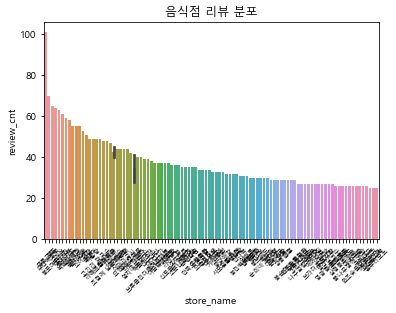

In [8]:
show_store_review_distribution_graph(DATA)

In [16]:
def show_stores_distribution_graph(dataframes):
    """
    Req. 1-3-5 각 음식점의 위치 분포를 지도에 나타냅니다.
    """
    stores = dataframes["stores"]
    stores_geo_json = 1
    m = folium.Map(
        location=[35.8, 127.6], tiles="OpenStreetMap", zoom_start=8
    )
    # 스크롤 기능
    plugins.MousePosition().add_to(m)
    # 전체화면 기능
    plugins.Fullscreen(
        position='topright',
        title='확장하기',
        title_cancel='나가기',
        force_separate_button=True
    ).add_to(m)
    
    return m

In [18]:
m = show_stores_distribution_graph(DATA)